In [34]:
import numpy as np
import skimage.filters as filters
from skimage import morphology
from skimage import measure
import matplotlib.pyplot as plt
import nrrd

import os

#### Utility functions

In [35]:
def otsu(xs):
    xs_thr = filters.threshold_otsu(xs)
    return_im = (xs < xs_thr).astype(np.float32)

# Returns a cylinder-shaped boolean array
#    ___
#   (___)     /|\
#   |   |      | z
#   |   |     \|/
#   |   |
#   (___)    /\
#   <-x->    / y
#           \/
# Offset is given in [z, x, y] position
def generate_cylinder(diameter, height, bounding_volume, offset = [0,0,0]):

    # First generate a cylinder
    # Then place it in a new bounding_volume-sized new volume with an offset
    radius = diameter / 2

    # Generate a disk
    x, y = np.meshgrid(np.arange(diameter), np.arange(diameter))
    disk_mask = np.sqrt((x -radius)**2 + (y - radius)**2) < radius
    # Extend the disk to a cylinder
    cyl_mask = np.repeat(disk_mask[np.newaxis, :, :], height, axis=0)

    # Calculate the indices to place the cylinder into the volume of zeroes
    vol_bounds = bounding_volume.shape
    cyl_bounds = cyl_mask.shape

    start = np.array([  (vol_bounds[0] - height)//2 + offset[0],
                        vol_bounds[1] // 2 - radius + offset[1],
                        vol_bounds[2] // 2 - radius + offset[2]
                    ], dtype=int)
    start = np.clip(start, a_min=0, a_max=None)

    end = np.array([(start[i] + cyl_bounds[i]) for i in range(3)], dtype=int)
    end = np.clip(end, a_min=None, a_max=vol_bounds)

    mask = np.zeros_like(bounding_volume)

    # Check if the cylinder is clipped and print a warning if necessary
    if np.any(start < 0) or np.any(end > vol_bounds):
        warning_msg = "Warning: Cylinder is clipped. "
        if start[0] < 0 or end[0] > vol_bounds[0]:
            warning_msg += " Dimension Z is clipped."
        if start[1] < 0 or end[1] > vol_bounds[1]:
            warning_msg += "Dimension X is clipped."
        if start[2] < 0 or end[2] > vol_bounds[2]:
            warning_msg += " Dimension Y is clipped."
        print(warning_msg)

    # This takes a long time (~10 sec.)
    mask[   start[0]:end[0],
            start[1]:end[1],
            start[2]:end[2]] = cyl_mask[:end[0] - start[0],
                                        :end[1] - start[1],
                                        :end[2] - start[2]]

    return mask


def place_array_in_middle(A, B):
    dims_A = A.shape
    dims_B = B.shape

    if any(dims_A[i] > dims_B[i] for i in range(3)):
        print("Error: Array A is larger than array B. Unable to place A in the middle.")
        return None

    start_indices = [(dims_B[i] - dims_A[i]) // 2 for i in range(3)]

    if any(start_indices[i] < 0 for i in range(3)):
        print("Warning: Array A does not fit completely inside array B. It may be partially outside.")

    result = np.zeros_like(B)
    result[start_indices[0]:start_indices[0] + dims_A[0],
           start_indices[1]:start_indices[1] + dims_A[1],
           start_indices[2]:start_indices[2] + dims_A[2]] = A

    return result

def apply_thresholds(img, thresholds):
    segm_img = img.copy()
    for i, t in enumerate(thresholds):
        segm_img[img >= t] = i + 1
    return segm_img


# Input: a 2D array where each instance is a (group of the same) unique integer(s)
def plot_labelled_slice(image, plot_labels = True):
    # Overlay label numbers on the labeled shapes
    # Only iterate over the labels that are actually in this image
    labels_in_image = list(np.unique(image))
    labels_in_image.remove(0)       # This would be background

    plt.imshow(image - min(labels_in_image) + 1, vmin=0, cmap='nipy_spectral', interpolation = 'none')

    if(not plot_labels): return

    for label_num in labels_in_image:
        # Find the coordinates of the labeled shape
        ys, xs = np.where(image == label_num)

        # if len(centroid_x) > 0 and len(centroid_y) > 0:
        # Calculate the centroid coordinates
        centroid_x = np.mean(xs)
        centroid_y = np.mean(ys)

        # Adjust the centroid coordinates with offsets
        label_x = centroid_x + 10
        label_y = centroid_y + 10

        # Check if the label position extends beyond the image boundaries
        image_height, image_width = image.shape
        if label_x >= image_width - 1:
            label_x = image_width - 1
        if label_y >= image_height - 1:
            label_y = image_height - 1

        # Display the label number at the centroid position
        plt.text(label_x, label_y, str(label_num), color='white',
                fontsize=10, ha='center', va='center')

    plt.show()

def plot_imgs(height=6, cmap="gray", colorbar=True, clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    it = 0
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(clim, list):
            pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim[it], interpolation = 'none')
        else:
            pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim, interpolation = 'none')
        if colorbar: fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
        it += 1

    fig.tight_layout()
    plt.show()

#### Importing

Importing 'B2.2.nrrd'
Volume has been imported. Shape: (1596, 992, 992)


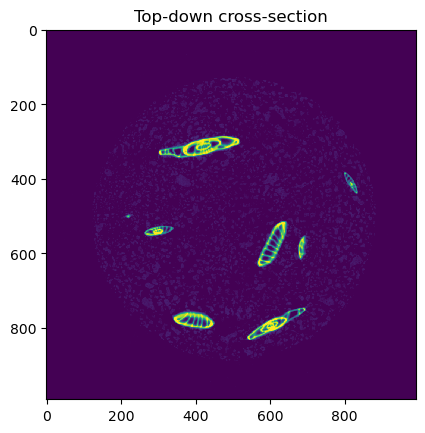

In [36]:
# Load a 3D .nrrd file
nrrd_path = r"path/to/a/group-scan.nrrd"

print(f'Importing \'{os.path.basename(nrrd_path)}\'')
volume, header = nrrd.read(nrrd_path)

# Optionally, rotate the volume such that its dimensions are [z, x, y]
# volume = np.rot90(volume, axes=(0,2))

print(f'Volume has been imported. Shape: {volume.shape}')

# NOTE: This image must yield a top-down cross-section
# If not, change the rotation a few lines above
plt.imshow(volume[volume.shape[0] // 2], interpolation = 'none')
plt.title('Top-down cross-section')
plt.show()


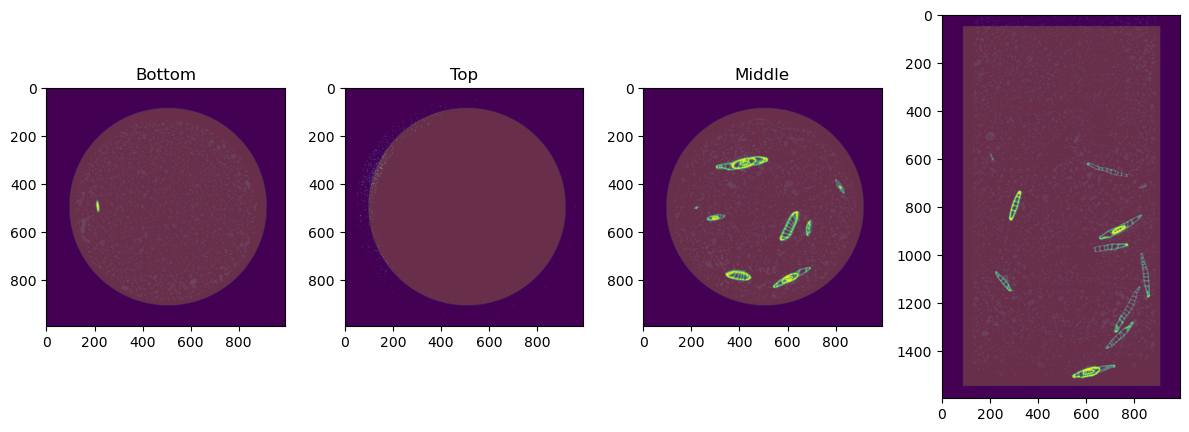

In [37]:
### Create and align tube mask ###
tube_diameter = 820
tube_height = volume.shape[0] - 100
tube_offset = [0,0,10]
tube_mask = generate_cylinder(tube_diameter, tube_height, volume, tube_offset)

## Preview whether the tube_mask will be applied correctly by overlaying it over the data
preview_bottom = (volume.shape[0] - tube_height) // 2
preview_top = preview_bottom + tube_height - 1
preview_middle = preview_bottom + (preview_top - preview_bottom) // 2
preview_slices = [preview_bottom, preview_top, preview_middle]
preview_names = ['Bottom', 'Top', 'Middle']

def preview_mask(slice, ax, title):
    ax.set_title(title)
    ax.imshow(volume[slice])
    ax.imshow(tube_mask[slice], alpha = 0.2)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))

[preview_mask(preview_slices[i], axes[i], preview_names[i]) for i in range(3)]

middle_slice = volume.shape[-1] // 2
axes[3].imshow(volume[:, :, middle_slice])
axes[3].imshow(tube_mask[:, :, middle_slice], alpha=0.2)

plt.tight_layout()
plt.show()


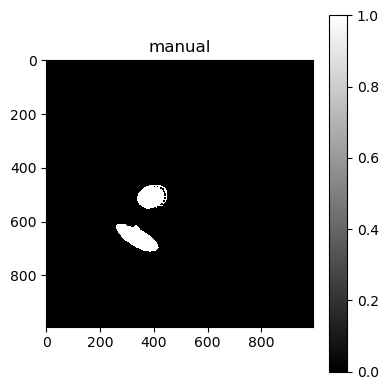

In [25]:
### Find and apply thresholds ###
masked_volume = tube_mask * volume

debug_slice_index = 252

## Workflow 1 - Multi-otsu
# n_classes = 4
# bins = 32
# otsu_thresholds = filters.threshold_multiotsu(masked_volume, classes=n_classes, nbins=bins)
# print(f'Otsu thresholds: {otsu_thresholds}')
# otsu_thr_volume = apply_thresholds(volume, otsu_thresholds)
# otsu_bin_volume = otsu_thr_volume == 3
# plot_imgs(otsu=otsu_bin_volume[debug_slice_index])

## Workflow 2 - Manual thresholding, followed in paper
manual_threshold = 63
manual_bin_volume = masked_volume > manual_threshold
plot_imgs(manual = manual_bin_volume[debug_slice_index], height=4)

# Rename final volume
bin_volume = manual_bin_volume

In [27]:
erosion_strength = 3
footprint = morphology.ball(radius=erosion_strength)

use_erode = True        # Whether the data should be eroded to prevent siamese specimens
use_upsample = False    # Optionally downsample, erode, upsample to speed up the process
if (use_erode):
    if (use_upsample):
        print('Applying upsampling')
        from skimage.transform import rescale
        upsampled = rescale(bin_volume, 2)
        print('Upsampled shape: ', upsampled.shape)

        eroded = morphology.binary_erosion(upsampled, footprint=footprint)
        del upsampled

        eroded = rescale(eroded, 0.5)
    else:
        print('Applying erosion')
        eroded = morphology.binary_erosion(bin_volume, footprint=footprint)
else:
    eroded = bin_volume

Applying erosion


In [28]:
# Remove small, insignificant bits
cleaned = morphology.remove_small_objects(eroded, min_size=2000, connectivity=1)

# Find the actual disconnected specimens and label them
labeled_volume, num_islands = measure.label(cleaned, connectivity=1, return_num = True)
print(f'Found {num_islands} islands')

Found 29 islands


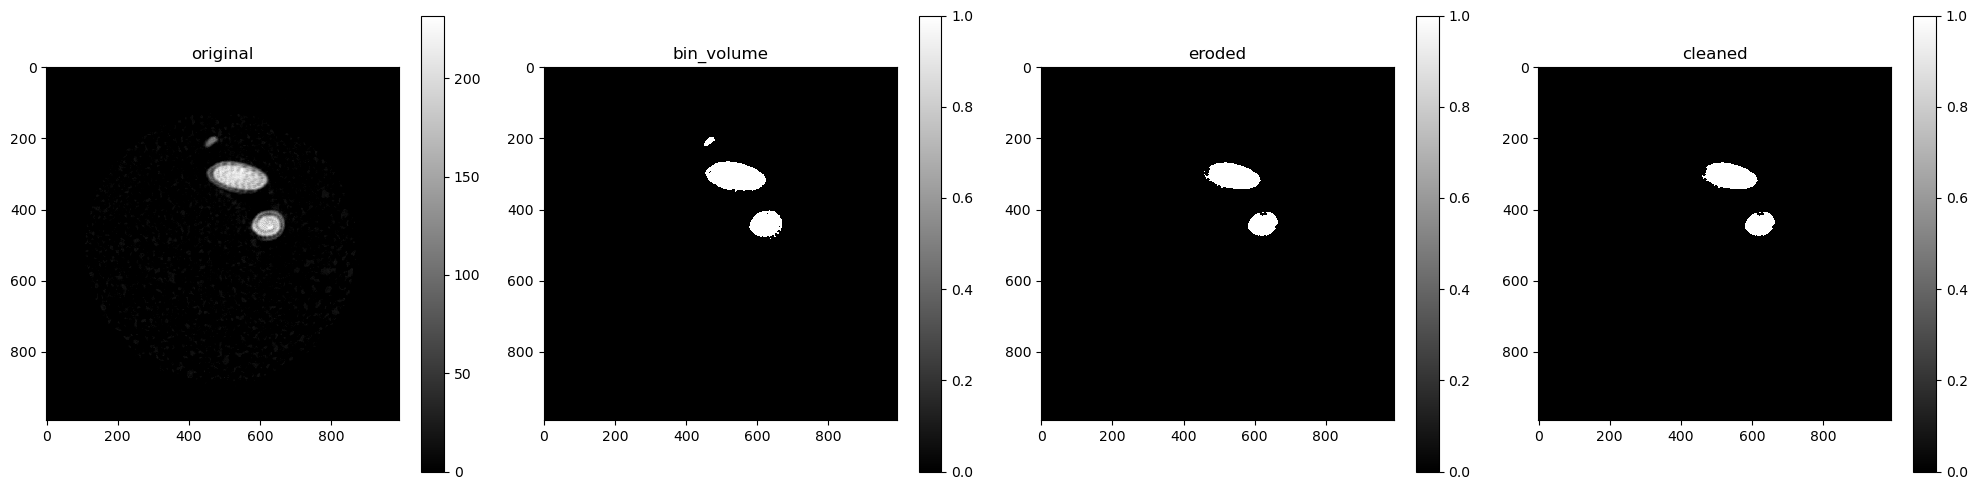

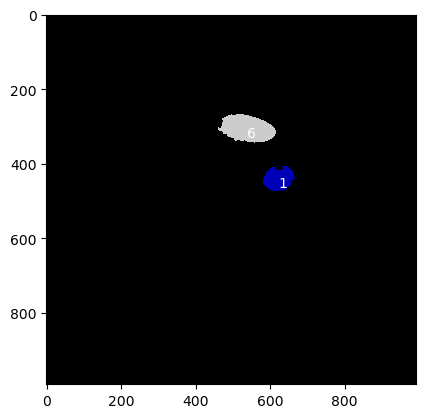

In [29]:
## Preview results so far
slice_index = 620

plot_imgs(original=volume[slice_index], binary_volume=bin_volume[slice_index], eroded=eroded[slice_index], cleaned=cleaned[slice_index], height=5)
plot_labelled_slice(labeled_volume[slice_index])

#### Preview and export the specimens

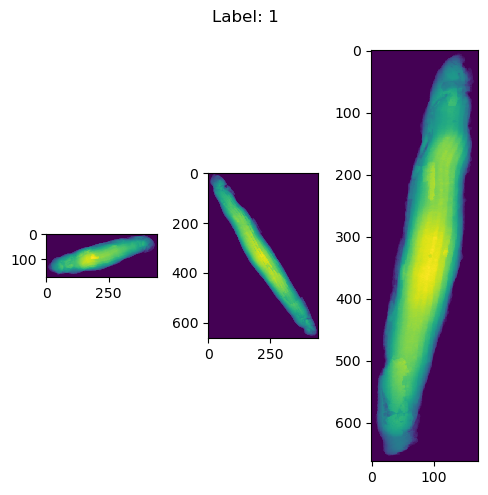

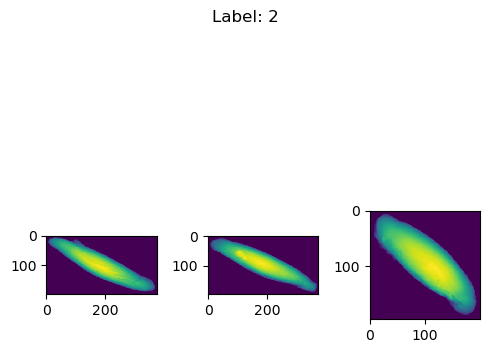

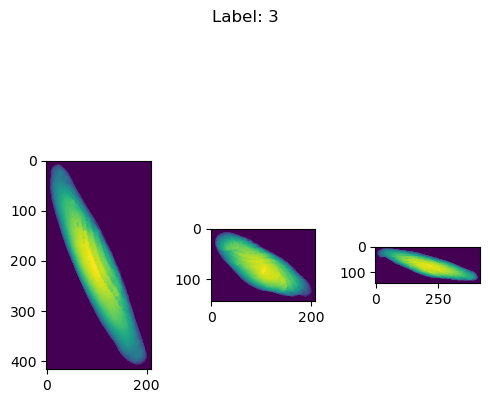

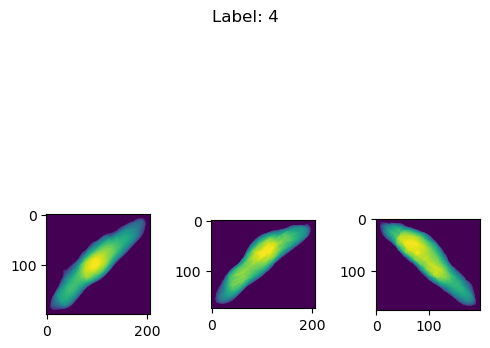

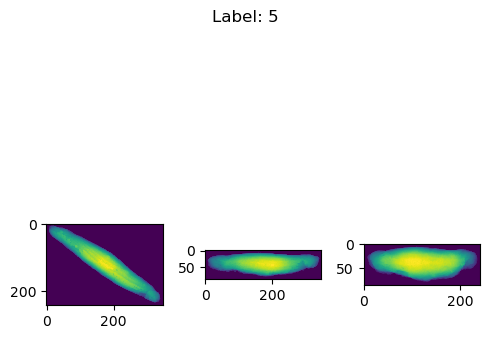

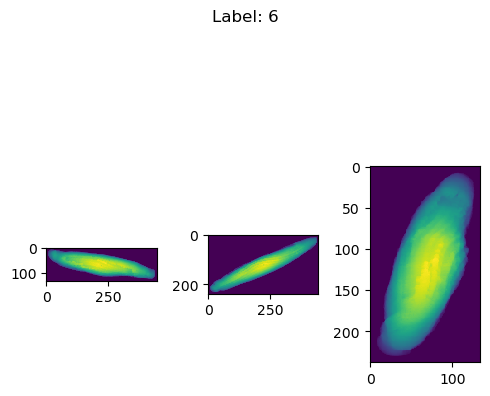

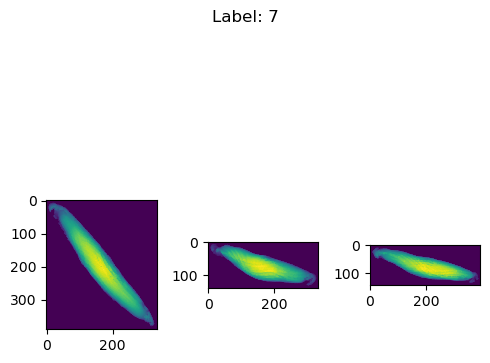

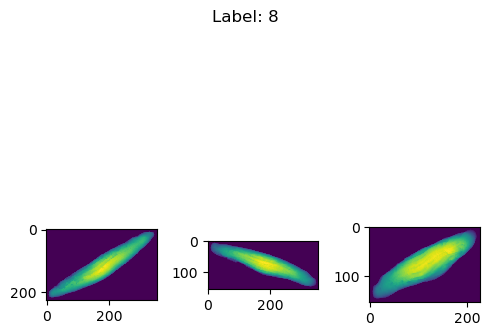

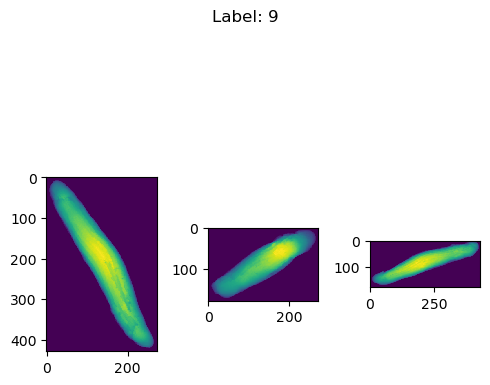

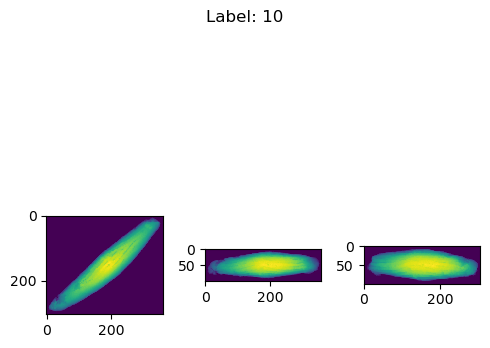

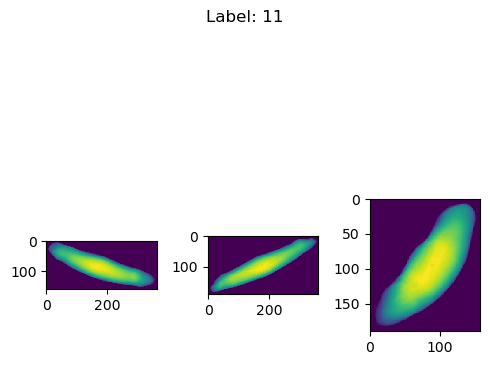

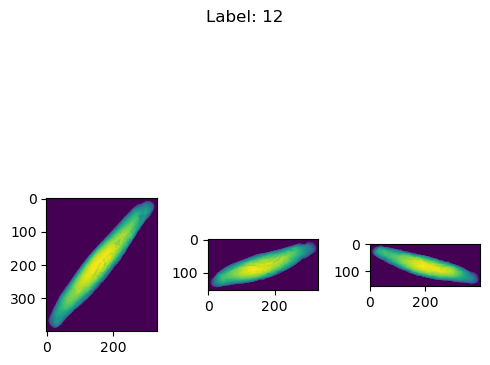

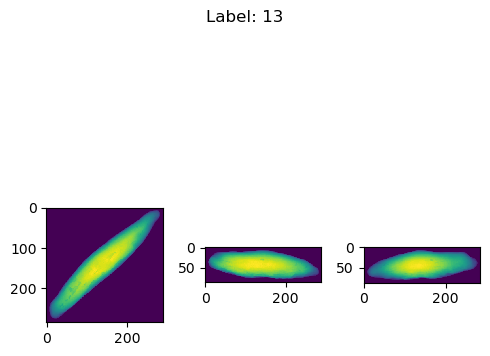

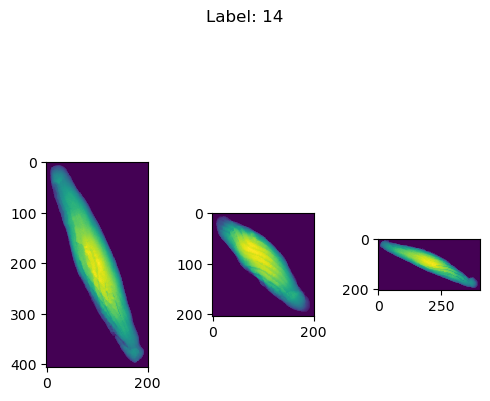

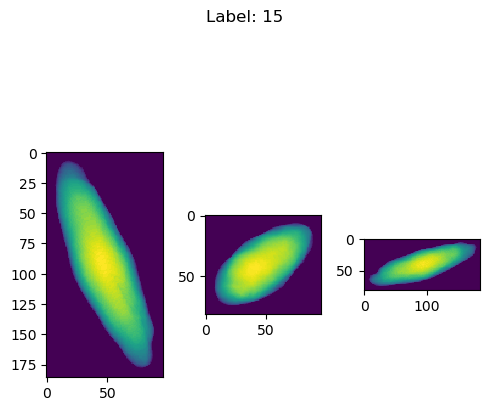

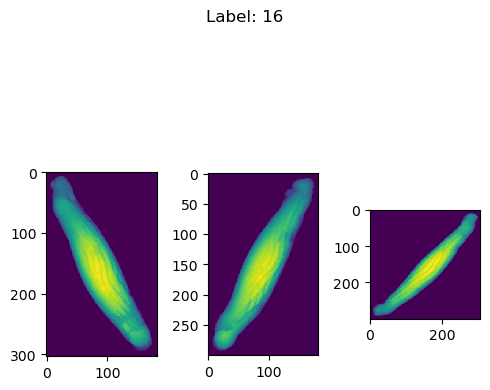

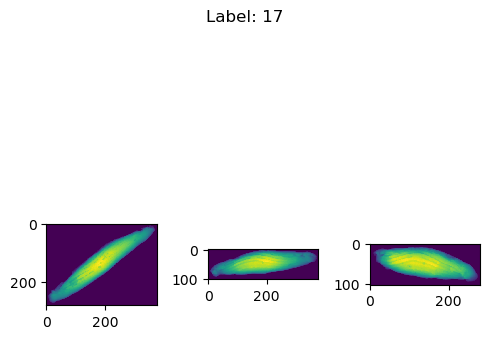

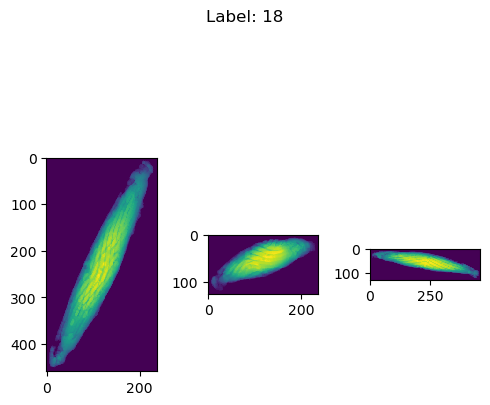

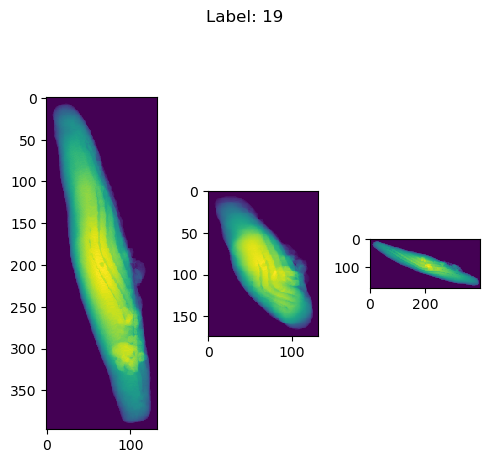

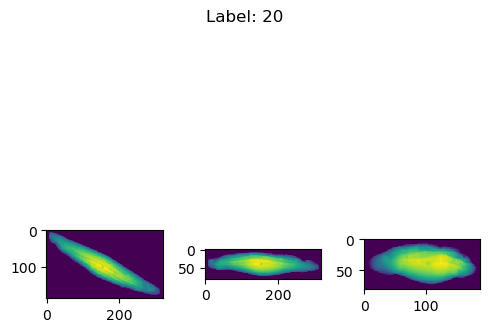

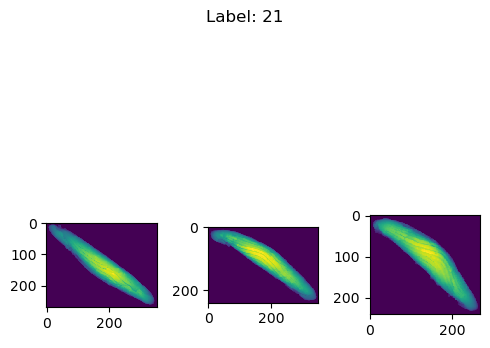

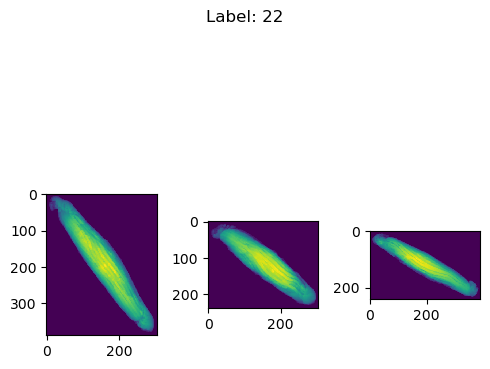

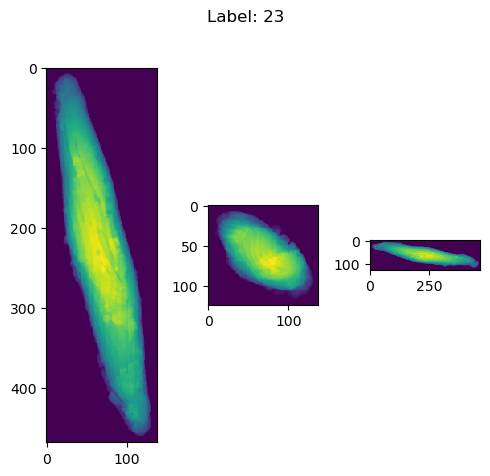

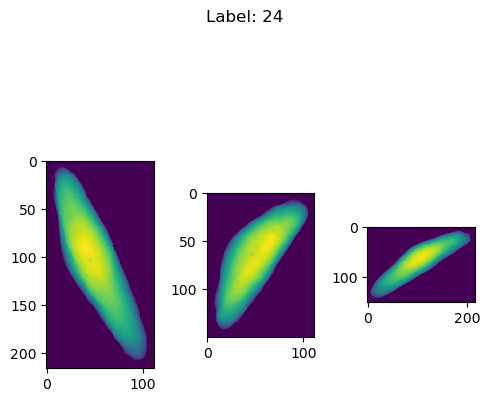

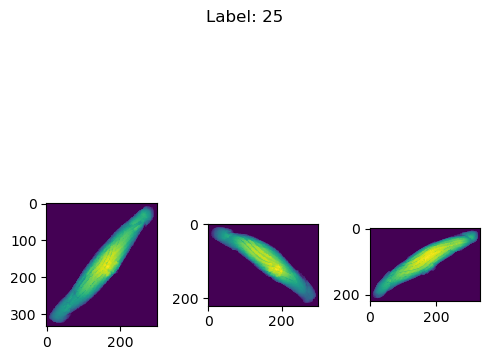

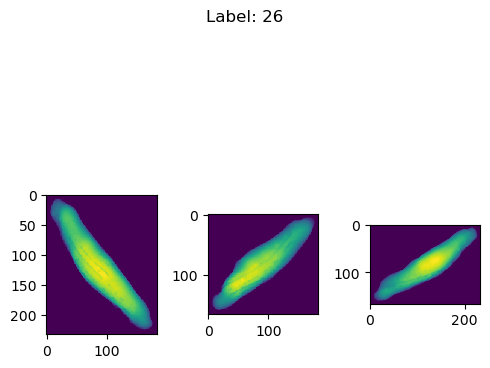

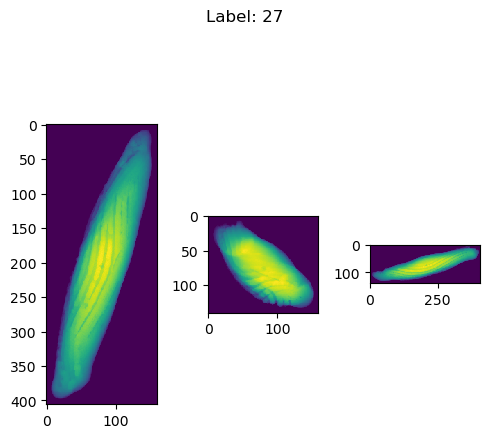

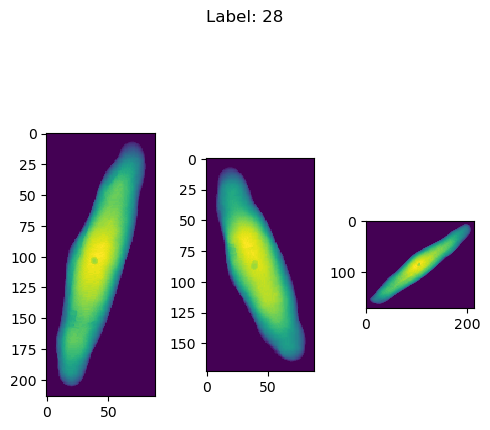

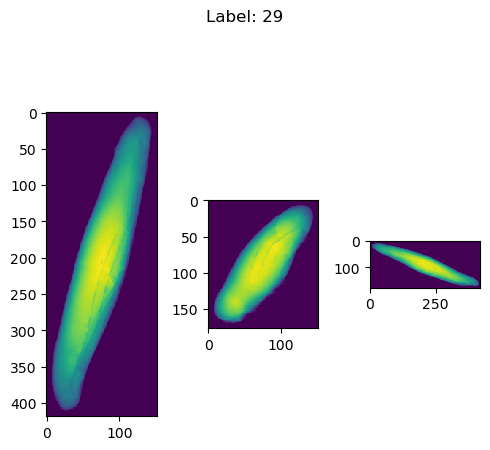

In [33]:
def plot_subvol(vol, title):
    # Create slices of the volume in all 3 dimensions
    slices = [np.sum((vol > 0), axis=-3), np.sum((vol > 0), axis=-2), np.sum((vol > 0), axis=-1)]

    # Plot the slices side-by-side
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(5, 5))
    [ax[i].imshow(slices[i], interpolation='none') for i in range(3)]

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

bboxes = measure.regionprops(labeled_volume)
bboxes = {x.label: x.bbox for x in bboxes}

specimens = dict()

for label, bbox in bboxes.items():
    minx, miny, minz, maxx, maxy, maxz = bbox
    
    # After testing, it was found some padding was needed
    pad = 10
    minx -= pad
    miny -= pad
    minz -= pad
    maxx += pad
    maxy += pad
    maxz += pad
    
    label_bbox = labeled_volume[minx:maxx, miny:maxy, minz:maxz] == label
    subvol = volume[minx:maxx, miny:maxy, minz:maxz] * label_bbox
    
    # Dilate subvolume to undo erosion artifacts
    dilation_strength = 3
    footprint = morphology.ball(radius=dilation_strength)
    subvol = morphology.dilation(subvol, footprint=footprint)

    plot_subvol(subvol, f'Label: {label}')
    
    specimens[label] = subvol
    
    # Optionally check if the dilation is strong enough by comparing dilated subvolume
    #   with the un-eroded volume contained in the subvolume's bounding box
    # plot_subvol(bin_volume[minx:maxx, miny:maxy, minz:maxz] * volume[minx:maxx, miny:maxy, minz:maxz], f'Raw label: {label}')

In [ ]:
## EXPORT SUBVOLUMES ##
import os
from tqdm.autonotebook import tqdm

# Note: manually exclude specimens from being exported by adding their labels to `excluded_labels` for e.g. touching foraminifera
excluded_labels = [3, 5, 8, 17, 23, 25, 27]

export_dir = r'/your/export/directory'

if len(os.listdir(export_dir)) == 0:

    for label, subvol in tqdm(specimens.items(), desc='Exporting...'):
        if label in excluded_labels:
            continue

        nrrd.write(os.path.join(export_dir, f'specimen-{label}.nrrd'), subvol)
else:
    print(f'{export_dir} already contains files! Current files will not be exported.')
    print(os.listdir(export_dir))